In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
import pingouin as pg
import warnings
warnings.filterwarnings('ignore')

На этот раз ситуация следующая: вы работаете в приложении по доставке готовых продуктов.
К вам пришел коллега с результатами двух тестов:

В первом тестировали разрешение фотографий блюд в приложении: пользователям показывались либо прямоугольные,
либо новые квадратные 
Во втором: была обновлена кнопка заказа, и часть юзеров видела старый вариант, а часть – новый
    
Коллега пришел к вам с просьбой: он посмотрел на графики и предположил, что среди групп могут встретиться различия.
Ваша задача – помочь ему проверить гипотезы, сделать соответствующие выводы на основе статистических тестов и принять решения.

Описание данных
5_task_1:

id – id клиента в эксперименте
group – в каком разрешении показывались картинки (A – прямоугольные 16:9, B – квадратные, C – прямоугольные 12:4)
events – сколько блюд суммарно было заказано за период


5_task_2:

id – id клиента в эксперименте
segment – сегмент (high/low)
group – вид кнопки (control – старая версия, test – новая версия)
events – сколько блюд суммарно было заказано за период

In [2]:
#по картинкам
df1 = pd.read_csv('5_task_1.csv')
df1

,id,group,events
0,16046,A,14
1,18712,A,41
2,3268,A,30
3,22633,A,37
4,28071,A,38
...,...,...,...
29995,22932,C,38
29996,21787,C,25
29997,5054,C,34
29998,10254,C,27


In [5]:
#по кнопке
df2 = pd.read_csv('5_task_2.csv')
df2

,id,group,segment,events
0,83440,test,high,78.0
1,96723,test,high,71.0
2,68719,test,high,80.0
3,50399,test,high,80.0
4,95613,test,high,78.0
...,...,...,...,...
99995,60695,control,low,15.0
99996,5934,control,low,16.0
99997,30046,control,low,22.0
99998,26474,control,low,21.0


**1. Анализ формата картинки**

In [17]:
#проверим, какой формат фотографий блюд является наилучшим
#т.е. в какой из групп в среднем покупали больше всего при помощи ANOVA

photo_A = df1.query("group == 'A'").events
photo_B = df1.query("group == 'B'").events
photo_C = df1.query("group == 'C'").events


In [8]:
#проверим, являются ли дисперсии внутри групп гомогенными
#с помощью теста Левена

st.levene(photo_A, photo_B, photo_C)

LeveneResult(statistic=2.2622596339318037, pvalue=0.1041327199523974)

То есть дисперии гомогенны

In [13]:
#убедимся, что данные распределены нормально
print(f'Для photo_A:', st.normaltest(photo_A))
print(f'Для photo_B:', st.normaltest(photo_B))
print(f'Для photo_C:', st.normaltest(photo_C))

Для photo_A: NormaltestResult(statistic=2.1034599402238734, pvalue=0.3493328906085719)
Для photo_B: NormaltestResult(statistic=0.8410715800223014, pvalue=0.6566948749848232)
Для photo_C: NormaltestResult(statistic=3.243725809054571, pvalue=0.19753037588314626)


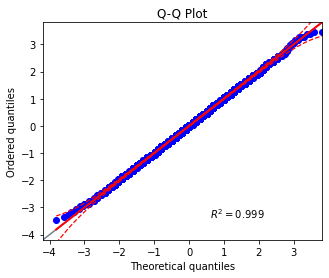

In [16]:
pg.qqplot(photo_A);
pg.qqplot(photo_B);
pg.qqplot(photo_C);

In [ ]:
То есть данные во всех выборках распределены нормально

In [ ]:
#проверим, какой формат фотографий блюд является наилучшим
#т.е. в какой из групп в среднем покупали больше всего при помощи ANOVA

st.f_oneway(photo_A, photo_B, photo_C)

In [ ]:
То есть хотя бы одна группа будет отличаться от другой

In [18]:
#теперь используем критерий Тьюки и определим, между какими группами есть статистически значимые различия
pg.pairwise_tukey(data=df1, dv='events', between='group')

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,A,B,29.5796,37.6136,-8.0340,0.140894,-57.021604,0.001,-0.806377
1,A,C,29.5796,27.4703,2.1093,0.140894,14.970833,0.001,0.211712
2,B,C,37.6136,27.4703,10.1433,0.140894,71.992436,0.001,1.018089


То есть между всеми шруппами есть статистически значимые различия

In [20]:
#Так какие картинки в итоге будем использовать?
#те, у которых самое высокое среднее значение по events
dif_photos = df1.groupby('group', as_index=False) \
    .agg({'events': 'mean'}) \
    .sort_values('events', ascending=False)
dif_photos

,group,events
1,B,37.6136
0,A,29.5796
2,C,27.4703


In [ ]:
То есть берем картинки B

**2. Анализ кнопки**

In [23]:
df2

,id,group,segment,events
0,83440,test,high,78.0
1,96723,test,high,71.0
2,68719,test,high,80.0
3,50399,test,high,80.0
4,95613,test,high,78.0
...,...,...,...,...
99995,60695,control,low,15.0
99996,5934,control,low,16.0
99997,30046,control,low,22.0
99998,26474,control,low,21.0


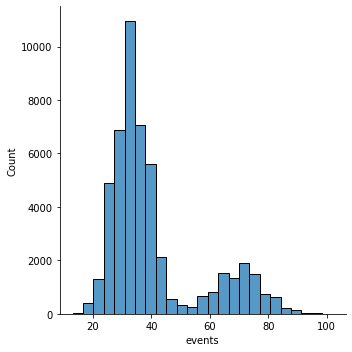

In [34]:
#визуализируем распределение events для тестовой группы
sns.displot(df2.query("group == 'test'").events, bins=25);

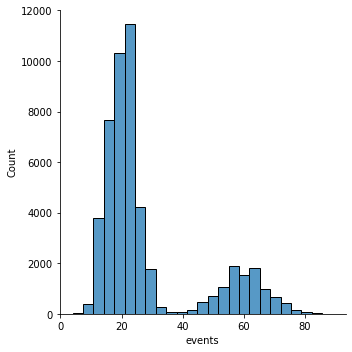

In [31]:
#визуализируем распределение events для контрольной группы
sns.displot(df2.query("group == 'control'").events, bins=25);

In [47]:
#посчитаем среднее, медиану и стандартное отклонение events в разбивке по группе и по сегменту пользователя

button_stats = df2.groupby(['group', 'segment']) \
    .agg({'events': ['mean', 'median', 'std']}) 
    
button_stats

events                 
                      mean median       std
group   segment                            
control high     59.970800   60.0  7.805347
        low      20.031575   20.0  4.473576
test    high     69.938500   70.0  8.403974
        low      33.025925   33.0  5.720845

In [53]:
#провериv, как пользователи отреагируют на изменение формата кнопки оформления заказа, с разбивкой по сегменту клиента
#то есть многофакторный дисперсионный анализ

pg.anova(data=df2, dv='events', between=['group', 'segment'])

,Source,SS,DF,MS,F,p-unc,np2
0,group,3.837195e+06,1.0,3.837195e+06,112031.864119,0.000000e+00,0.528383
1,segment,2.362480e+07,1.0,2.362480e+07,689756.377484,0.000000e+00,0.873383
2,group * segment,3.664244e+04,1.0,3.664244e+04,1069.823273,2.060261e-233,0.010585
3,Residual,3.424956e+06,99996.0,3.425093e+01,NaN,NaN,NaN


То есть между какими-то комбинациями существуют статистически значимые различия

In [55]:
#проведем тесть Тьюки, чтобы выяснить, между какими группами есть различия
#для этого сначала создадим комбинации

# Создаем комбинированную группу
df2['combination'] = df2['group'] + ' / ' + df2['segment']
df2

,id,group,segment,events,combination
0,83440,test,high,78.0,test / high
1,96723,test,high,71.0,test / high
2,68719,test,high,80.0,test / high
3,50399,test,high,80.0,test / high
4,95613,test,high,78.0,test / high
...,...,...,...,...,...
99995,60695,control,low,15.0,control / low
99996,5934,control,low,16.0,control / low
99997,30046,control,low,22.0,control / low
99998,26474,control,low,21.0,control / low


In [56]:
#проведем тесть Тьюки, чтобы выяснить, между какими комбинациями есть различия
pg.pairwise_tukey(data=df2, dv='events', between='combination')

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,control / high,control / low,59.970800,20.031575,39.939225,0.065432,610.391461,0.001,6.824282
1,control / high,test / high,59.970800,69.938500,-9.967700,0.082766,-120.432523,0.001,-1.703109
2,control / high,test / low,59.970800,33.025925,26.944875,0.065432,411.798717,0.001,4.603981
3,control / low,test / high,20.031575,69.938500,-49.906925,0.065432,-762.727892,0.001,-8.527429
4,control / low,test / low,20.031575,33.025925,-12.994350,0.041383,-314.002699,0.001,-2.220314
5,test / high,test / low,69.938500,33.025925,36.912575,0.065432,564.135148,0.001,6.307128


In [ ]:
То есть для обоих сегментов показатели статистически значимо _увеличились_ по сравнению с контрольной группой

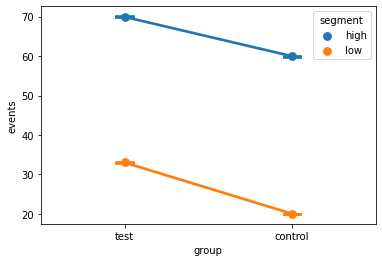

In [58]:
#визуализируем результаты теста
sns.pointplot(data=df2, x='group', y='events', hue='segment', capsize=0.1);

Фактор group оказался значимым, фактор segment – значимым, их взаимодействие – значимо.
Судя по графику, для всех групп среднее значение events увеличилось, поэтому решение: выкатываем новую версию.